# READ

1. API is in User Variables for User in Environemtn Variables named "NEPTUNE_API_TOKEN"
2. If internet sucks, set mode to offline
4. When offline runs are saved locally, sync it with | neptune sync -p "New-Thesis/KFold-Test" --offline-only |
- make sure it is in venv mode | (venv) PS C:\Users\user\Documents\Machine-Learning-Hub-1\ImageClassification\Neptune-Thesis> |
5. Delete the offline folder or use | neptune clear |

# Load Libraries

In [1]:
import tqdm
import os
import cv2
import imghdr
import image_to_numpy
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime
import itertools
from numpy.random import default_rng

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast, RandomBrightness, Rescaling, Resizing
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, ReLU
from tensorflow.keras.metrics import F1Score, Precision, Recall, CategoricalAccuracy
from tensorboard.plugins.hparams import api as hp
import sklearn
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import StratifiedKFold

from time import perf_counter
import math

import neptune
from neptune.integrations.tensorflow_keras import NeptuneCallback

# Show Model Summary if Needed

In [ ]:
model = tf.keras.models.load_model("./model.keras")
model.summary()

# Initialize Functions

In [50]:
model_name = "INI-V0-1"
checkpoint_path = f'./checkpoints/{model_name}/FOLD-'

In [98]:
def make_model(params):
    model = Sequential()
    model.add(RandomFlip(mode='horizontal', seed=1, input_shape=(256,256,3)))
    model.add(RandomRotation(factor=0.2, seed=1))
    
    model.add(Conv2D(input_shape=(256,256,3), filters=16, kernel_size=(3,3), padding="same"))
    model.add(BatchNormalization(epsilon=0.0001))
    model.add(ReLU())
    model.add(MaxPooling2D())
    
    model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same"))
    model.add(BatchNormalization(epsilon=0.0001))
    model.add(ReLU())
    model.add(MaxPooling2D())
    
    model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same"))
    model.add(BatchNormalization(epsilon=0.0001))
    model.add(ReLU())
    model.add(MaxPooling2D())
    
    model.add(Flatten())
    model.add(Dropout(0.2, seed=1))
    model.add(Dense(units=128,activation="relu"))
    model.add(Dense(units=64,activation="relu"))
    
    model.add(Dense(units=1, activation="sigmoid"))


    optimizer = tf.keras.optimizers.Adam(
        learning_rate=params["lr"],
    )
    
    model.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [99]:
def create_callbacks(counter):
    neptune_cbk = NeptuneCallback(run=run, base_namespace="training")

    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path + str(counter), 
                                                                 monitor='val_loss', 
                                                                 mode='auto', 
                                                                 save_best_only=True, 
                                                                 verbose=1)
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                   patience=15,
                                                  )
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                         factor=0.6, 
                                                         patience=10, 
                                                         min_delta=0.001, 
                                                         mode='auto', 
                                                         verbose=1)
    # return [reduce_lr, cp_callback]
    return [neptune_cbk, reduce_lr, cp_callback]

In [12]:
def plot_loss(hist):
    fig = plt.figure(figsize=(3,2))
    plt.plot(hist.history['loss'], color='teal', label='loss')
    plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
    plt.suptitle('Loss')
    plt.legend(loc='upper right')
    plt.show()
    return fig

In [13]:
def plot_acc(hist):
    fig = plt.figure(figsize=(3,2))
    plt.plot(hist.history['accuracy'], color='teal', label='acc')
    plt.plot(hist.history['val_accuracy'], color='orange', label='val_acc')
    plt.suptitle('Accuracy')
    plt.legend(loc='upper left')
    plt.show()
    return fig

In [14]:
def avg_rate(metric_list):
    return sum(metric_list) / len(metric_list)

# Prepare Dataset

In [16]:
data_dir = "D:\DATASETS\For-Issue-Classifier\Dataset-To-Use"

In [31]:
labels = ['Issue', 'No Issue']
X_train = []
y_label_idx = []
image_size = 256
for i in labels:
    folderPath = os.path.join(data_dir, i)
    for j in os.listdir(folderPath):
        img = image_to_numpy.load_image_file(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_label_idx.append(labels.index(i))

In [34]:
X_train = np.array(X_train)
y_label_idx = np.array(y_label_idx)

X_train_scaled = X_train.astype(np.float32) / 255.0

In [40]:
len(X_train) - 652

162

In [35]:
rng = default_rng(seed=1)

issue_idx = rng.choice(np.arange(0,407), size=81, replace=False)
no_issue_idx = rng.choice(np.arange(407,814), size=81, replace=False)
total_test_idx = np.concatenate((issue_idx, no_issue_idx), axis=None)

In [36]:
def train_test_X(X_train_scaled):    
    test_x = X_train_scaled[total_test_idx]
    train_x = np.delete(X_train_scaled, total_test_idx, axis=0)
    return train_x, test_x

def train_test_y(y_label_idx):
    test_y = y_label_idx[total_test_idx]
    train_y = np.delete(y_label_idx, total_test_idx, axis=0)
    return train_y, test_y

In [37]:
train_x, holdout_x = train_test_X(X_train_scaled)
train_y, holdout_y = train_test_y(y_label_idx)

In [38]:
print(len(train_x), len(holdout_x))

652 162


In [46]:
print(holdout_y[:10])

[0 0 0 0 0 0 0 0 0 0]


# Run KFOLD

In [ ]:
# model_name = "INI-V0-1"

In [47]:
kfold = StratifiedKFold(n_splits=8, shuffle=True, random_state=1)

In [100]:
project_name = "New-Thesis/KFOLD-INI"
# api_token = <It is already initialized in environemnt variables>
params = {
    "lr": 0.001, 
    "epochs": 40, 
    "batch_size": 8}

In [ ]:
# CHECK MODEL VERION IN THE FOR LOOP OF KFOLDS WHEN SAVING
# CHECK MODEL VERION IN THE FOR LOOP OF KFOLDS WHEN SAVING
# CHECK MODEL VERION IN THE FOR LOOP OF KFOLDS WHEN SAVING
# CHECK MODEL VERION IN THE FOR LOOP OF KFOLDS WHEN SAVING
# CHECK MODEL VERION IN THE FOR LOOP OF KFOLDS WHEN SAVING
# CHECK MODEL VERION IN THE FOR LOOP OF KFOLDS WHEN SAVING
# CHECK MODEL VERION IN THE FOR LOOP OF KFOLDS WHEN SAVING
# CHECK MODEL VERION IN THE FOR LOOP OF KFOLDS WHEN SAVING
# CHECK MODEL VERION IN THE FOR LOOP OF KFOLDS WHEN SAVING
# CHECK MODEL VERION IN THE FOR LOOP OF KFOLDS WHEN SAVING
# CHECK MODEL VERION IN THE FOR LOOP OF KFOLDS WHEN SAVING
# CHECK MODEL VERION IN THE FOR LOOP OF KFOLDS WHEN SAVING

In [ ]:
counter = 0
start = perf_counter()
for train, test in kfold.split(train_x, train_y):
    start_fold = perf_counter()

    model = make_model(params)
    train_dataset = tf.data.Dataset.from_tensor_slices((train_x[train], train_y[train]))
    train_fold = train_dataset.shuffle(buffer_size=train_dataset.cardinality(), seed=1).batch(params['batch_size'])
    
    test_dataset = tf.data.Dataset.from_tensor_slices((train_x[test], train_y[test]))
    test_fold = test_dataset.shuffle(buffer_size=test_dataset.cardinality(), seed=1).batch(params['batch_size'])
    
    hist = model.fit(train_fold, 
                     validation_data=test_fold,
                     batch_size=params['batch_size'],
                     epochs=params['epochs'],
                     verbose=1,
                     callbacks=create_callbacks(counter))
    end_fold = perf_counter()

    plot_loss(hist)
    plot_acc(hist)

    break
    
    counter += 1

end = perf_counter()

print(f'Total Training Time: {math.floor((end-start)/3600) } hour(s) and {math.floor((end-start)/60)%60} mins')

In [96]:
# EVALUATING ==================================================
model = tf.keras.models.load_model(checkpoint_path + str(counter))

pre = Precision()
rec = Recall()
b_acc = tf.keras.metrics.BinaryAccuracy()
for batch in test_fold.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X, verbose=0)
    pre.update_state(y, yhat)
    rec.update_state(y, yhat)
    b_acc.update_state(y, yhat)
    

# PRINTING RESULTS ===========================================
print(f'Fold Training Time: {math.floor((end_fold-start_fold)/3600) } hour(s) and {math.floor((end_fold-start_fold)/60)%60} mins')
print(f'Precision: {pre.result().numpy() * 100}  -  Recall: {rec.result().numpy() * 100}')
print(f'Accuracy: {b_acc.result().numpy() * 100}')
print(f'F1Score: {2 * (pre.result().numpy() * rec.result().numpy()) / (pre.result().numpy() + rec.result().numpy())}')

Fold Training Time: 0 hour(s) and 7 mins
Precision: 69.9999988079071  -  Recall: 68.29268336296082
Accuracy: 69.51219439506531
F1Score: 0.6913580156456033


[neptune] [info   ] Neptune initialized. Open in the app: offline/4d9caa28-1f98-4c57-82ef-45e5bb2e395a
Epoch 1/40
72/72 [==============================] - ETA: 0s - loss: 2.2986 - accuracy: 0.5211
Epoch 1: val_loss improved from inf to 1.58249, saving model to ./checkpoints/INI-V0-1\FOLD-0
INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-0\assets


INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-0\assets


72/72 [==============================] - 26s 288ms/step - loss: 2.2986 - accuracy: 0.5211 - val_loss: 1.5825 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/40
72/72 [==============================] - ETA: 0s - loss: 1.0678 - accuracy: 0.6088
Epoch 2: val_loss improved from 1.58249 to 0.72864, saving model to ./checkpoints/INI-V0-1\FOLD-0
INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-0\assets


INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-0\assets


72/72 [==============================] - 20s 283ms/step - loss: 1.0678 - accuracy: 0.6088 - val_loss: 0.7286 - val_accuracy: 0.5244 - lr: 0.0010
Epoch 3/40
72/72 [==============================] - ETA: 0s - loss: 0.8915 - accuracy: 0.6088
Epoch 3: val_loss did not improve from 0.72864
72/72 [==============================] - 14s 189ms/step - loss: 0.8915 - accuracy: 0.6088 - val_loss: 1.9135 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/40
72/72 [==============================] - ETA: 0s - loss: 0.9006 - accuracy: 0.6088
Epoch 4: val_loss did not improve from 0.72864
72/72 [==============================] - 14s 192ms/step - loss: 0.9006 - accuracy: 0.6088 - val_loss: 2.3340 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/40
72/72 [==============================] - ETA: 0s - loss: 0.6849 - accuracy: 0.6491
Epoch 5: val_loss did not improve from 0.72864
72/72 [==============================] - 14s 192ms/step - loss: 0.6849 - accuracy: 0.6491 - val_loss: 1.1712 - val_accuracy: 0.5244 - lr: 0.00

INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-0\assets


72/72 [==============================] - 19s 258ms/step - loss: 0.6358 - accuracy: 0.6702 - val_loss: 0.6215 - val_accuracy: 0.6463 - lr: 0.0010
Epoch 11/40
72/72 [==============================] - ETA: 0s - loss: 0.6034 - accuracy: 0.6877
Epoch 11: val_loss did not improve from 0.62153
72/72 [==============================] - 14s 189ms/step - loss: 0.6034 - accuracy: 0.6877 - val_loss: 0.7864 - val_accuracy: 0.5854 - lr: 0.0010
Epoch 12/40
72/72 [==============================] - ETA: 0s - loss: 0.6171 - accuracy: 0.6807
Epoch 12: val_loss did not improve from 0.62153
72/72 [==============================] - 14s 189ms/step - loss: 0.6171 - accuracy: 0.6807 - val_loss: 1.0692 - val_accuracy: 0.5610 - lr: 0.0010
Epoch 13/40
72/72 [==============================] - ETA: 0s - loss: 0.5920 - accuracy: 0.6877
Epoch 13: val_loss did not improve from 0.62153
72/72 [==============================] - 13s 188ms/step - loss: 0.5920 - accuracy: 0.6877 - val_loss: 0.7032 - val_accuracy: 0.5854 - lr

INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-0\assets


72/72 [==============================] - 20s 284ms/step - loss: 0.5335 - accuracy: 0.7175 - val_loss: 0.5991 - val_accuracy: 0.6829 - lr: 6.0000e-04
Epoch 23/40
72/72 [==============================] - ETA: 0s - loss: 0.5071 - accuracy: 0.7632
Epoch 23: val_loss did not improve from 0.59909
72/72 [==============================] - 14s 190ms/step - loss: 0.5071 - accuracy: 0.7632 - val_loss: 0.6974 - val_accuracy: 0.6829 - lr: 6.0000e-04
Epoch 24/40
72/72 [==============================] - ETA: 0s - loss: 0.5205 - accuracy: 0.7246
Epoch 24: val_loss did not improve from 0.59909
72/72 [==============================] - 14s 190ms/step - loss: 0.5205 - accuracy: 0.7246 - val_loss: 2.3495 - val_accuracy: 0.5000 - lr: 6.0000e-04
Epoch 25/40
72/72 [==============================] - ETA: 0s - loss: 0.5223 - accuracy: 0.7404
Epoch 25: val_loss did not improve from 0.59909
72/72 [==============================] - 14s 192ms/step - loss: 0.5223 - accuracy: 0.7404 - val_loss: 0.7938 - val_accuracy:

INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-0\assets


72/72 [==============================] - 19s 262ms/step - loss: 0.4575 - accuracy: 0.7737 - val_loss: 0.5845 - val_accuracy: 0.6951 - lr: 3.6000e-04
Epoch 34/40
72/72 [==============================] - ETA: 0s - loss: 0.4440 - accuracy: 0.8053
Epoch 34: val_loss did not improve from 0.58451
72/72 [==============================] - 14s 189ms/step - loss: 0.4440 - accuracy: 0.8053 - val_loss: 0.8060 - val_accuracy: 0.6341 - lr: 3.6000e-04
Epoch 35/40
72/72 [==============================] - ETA: 0s - loss: 0.4296 - accuracy: 0.8053
Epoch 35: val_loss did not improve from 0.58451
72/72 [==============================] - 14s 188ms/step - loss: 0.4296 - accuracy: 0.8053 - val_loss: 0.6294 - val_accuracy: 0.7073 - lr: 3.6000e-04
Epoch 36/40
72/72 [==============================] - ETA: 0s - loss: 0.4305 - accuracy: 0.8018
Epoch 36: val_loss did not improve from 0.58451
72/72 [==============================] - 14s 192ms/step - loss: 0.4305 - accuracy: 0.8018 - val_loss: 0.6398 - val_accuracy:

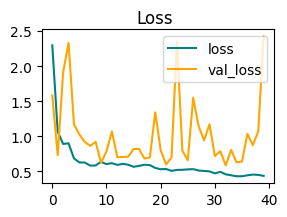

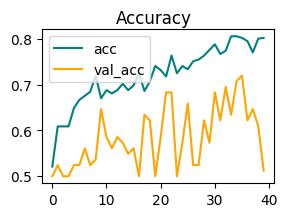

Fold Training Time: 0 hour(s) and 9 mins
Precision: 71.05262875556946  -  Recall: 65.85366129875183
Accuracy: 69.51219439506531
F1Score: 68.35443098595572
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/a4cc76d8-e0b7-4277-9645-4979695ac434
Epoch 1/40
72/72 [==============================] - ETA: 0s - loss: 3.1894 - accuracy: 0.5351
Epoch 1: val_loss improved from inf to 1.41090, saving model to ./checkpoints/INI-V0-1\FOLD-1
INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-1\assets


INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-1\assets


72/72 [==============================] - 24s 265ms/step - loss: 3.1894 - accuracy: 0.5351 - val_loss: 1.4109 - val_accuracy: 0.5122 - lr: 0.0010
Epoch 2/40
72/72 [==============================] - ETA: 0s - loss: 1.3534 - accuracy: 0.5754
Epoch 2: val_loss improved from 1.41090 to 0.84023, saving model to ./checkpoints/INI-V0-1\FOLD-1
INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-1\assets


INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-1\assets


72/72 [==============================] - 18s 246ms/step - loss: 1.3534 - accuracy: 0.5754 - val_loss: 0.8402 - val_accuracy: 0.5366 - lr: 0.0010
Epoch 3/40
72/72 [==============================] - ETA: 0s - loss: 1.1865 - accuracy: 0.5702
Epoch 3: val_loss did not improve from 0.84023
72/72 [==============================] - 13s 178ms/step - loss: 1.1865 - accuracy: 0.5702 - val_loss: 1.1052 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/40
72/72 [==============================] - ETA: 0s - loss: 0.9687 - accuracy: 0.5807
Epoch 4: val_loss did not improve from 0.84023
72/72 [==============================] - 13s 174ms/step - loss: 0.9687 - accuracy: 0.5807 - val_loss: 1.0499 - val_accuracy: 0.6341 - lr: 0.0010
Epoch 5/40
72/72 [==============================] - ETA: 0s - loss: 0.7119 - accuracy: 0.6491
Epoch 5: val_loss improved from 0.84023 to 0.59940, saving model to ./checkpoints/INI-V0-1\FOLD-1
INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-1\assets


INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-1\assets


72/72 [==============================] - 18s 254ms/step - loss: 0.7119 - accuracy: 0.6491 - val_loss: 0.5994 - val_accuracy: 0.6585 - lr: 0.0010
Epoch 6/40
72/72 [==============================] - ETA: 0s - loss: 0.7011 - accuracy: 0.6368
Epoch 6: val_loss did not improve from 0.59940
72/72 [==============================] - 13s 175ms/step - loss: 0.7011 - accuracy: 0.6368 - val_loss: 0.6512 - val_accuracy: 0.6341 - lr: 0.0010
Epoch 7/40
72/72 [==============================] - ETA: 0s - loss: 0.6445 - accuracy: 0.6702
Epoch 7: val_loss improved from 0.59940 to 0.56235, saving model to ./checkpoints/INI-V0-1\FOLD-1
INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-1\assets


INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-1\assets


72/72 [==============================] - 17s 242ms/step - loss: 0.6445 - accuracy: 0.6702 - val_loss: 0.5623 - val_accuracy: 0.6585 - lr: 0.0010
Epoch 8/40
72/72 [==============================] - ETA: 0s - loss: 0.6326 - accuracy: 0.6596
Epoch 8: val_loss did not improve from 0.56235
72/72 [==============================] - 13s 176ms/step - loss: 0.6326 - accuracy: 0.6596 - val_loss: 0.5772 - val_accuracy: 0.6829 - lr: 0.0010
Epoch 9/40
72/72 [==============================] - ETA: 0s - loss: 0.6059 - accuracy: 0.6965
Epoch 9: val_loss did not improve from 0.56235
72/72 [==============================] - 13s 176ms/step - loss: 0.6059 - accuracy: 0.6965 - val_loss: 0.6781 - val_accuracy: 0.6341 - lr: 0.0010
Epoch 10/40
72/72 [==============================] - ETA: 0s - loss: 0.6271 - accuracy: 0.6544
Epoch 10: val_loss did not improve from 0.56235
72/72 [==============================] - 13s 175ms/step - loss: 0.6271 - accuracy: 0.6544 - val_loss: 0.6616 - val_accuracy: 0.6585 - lr: 0.

INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-1\assets


72/72 [==============================] - 18s 245ms/step - loss: 0.6038 - accuracy: 0.6596 - val_loss: 0.5472 - val_accuracy: 0.7073 - lr: 0.0010
Epoch 17/40
72/72 [==============================] - ETA: 0s - loss: 0.5822 - accuracy: 0.6965
Epoch 17: val_loss did not improve from 0.54721
72/72 [==============================] - 13s 174ms/step - loss: 0.5822 - accuracy: 0.6965 - val_loss: 0.7970 - val_accuracy: 0.5854 - lr: 0.0010
Epoch 18/40
72/72 [==============================] - ETA: 0s - loss: 0.5913 - accuracy: 0.6684
Epoch 18: val_loss improved from 0.54721 to 0.49548, saving model to ./checkpoints/INI-V0-1\FOLD-1
INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-1\assets


INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-1\assets


72/72 [==============================] - 17s 242ms/step - loss: 0.5913 - accuracy: 0.6684 - val_loss: 0.4955 - val_accuracy: 0.7805 - lr: 0.0010
Epoch 19/40
72/72 [==============================] - ETA: 0s - loss: 0.6525 - accuracy: 0.6404
Epoch 19: val_loss did not improve from 0.49548
72/72 [==============================] - 13s 175ms/step - loss: 0.6525 - accuracy: 0.6404 - val_loss: 0.5668 - val_accuracy: 0.7561 - lr: 0.0010
Epoch 20/40
72/72 [==============================] - ETA: 0s - loss: 0.5701 - accuracy: 0.6965
Epoch 20: val_loss did not improve from 0.49548
72/72 [==============================] - 13s 176ms/step - loss: 0.5701 - accuracy: 0.6965 - val_loss: 0.5977 - val_accuracy: 0.6341 - lr: 0.0010
Epoch 21/40
72/72 [==============================] - ETA: 0s - loss: 0.5669 - accuracy: 0.6930
Epoch 21: val_loss improved from 0.49548 to 0.47454, saving model to ./checkpoints/INI-V0-1\FOLD-1
INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-1\assets


INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-1\assets


72/72 [==============================] - 17s 243ms/step - loss: 0.5669 - accuracy: 0.6930 - val_loss: 0.4745 - val_accuracy: 0.7561 - lr: 0.0010
Epoch 22/40
72/72 [==============================] - ETA: 0s - loss: 0.5713 - accuracy: 0.7070
Epoch 22: val_loss did not improve from 0.47454
72/72 [==============================] - 13s 175ms/step - loss: 0.5713 - accuracy: 0.7070 - val_loss: 0.6015 - val_accuracy: 0.7195 - lr: 0.0010
Epoch 23/40
72/72 [==============================] - ETA: 0s - loss: 0.5908 - accuracy: 0.6912
Epoch 23: val_loss did not improve from 0.47454
72/72 [==============================] - 13s 176ms/step - loss: 0.5908 - accuracy: 0.6912 - val_loss: 0.4902 - val_accuracy: 0.8293 - lr: 0.0010
Epoch 24/40
72/72 [==============================] - ETA: 0s - loss: 0.5603 - accuracy: 0.7246
Epoch 24: val_loss did not improve from 0.47454
72/72 [==============================] - 13s 176ms/step - loss: 0.5603 - accuracy: 0.7246 - val_loss: 0.6403 - val_accuracy: 0.6707 - lr

INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-1\assets


72/72 [==============================] - 18s 246ms/step - loss: 0.5657 - accuracy: 0.6982 - val_loss: 0.4627 - val_accuracy: 0.7805 - lr: 0.0010
Epoch 31/40
72/72 [==============================] - ETA: 0s - loss: 0.5421 - accuracy: 0.7246
Epoch 31: val_loss did not improve from 0.46265
72/72 [==============================] - 13s 175ms/step - loss: 0.5421 - accuracy: 0.7246 - val_loss: 0.6470 - val_accuracy: 0.6341 - lr: 0.0010
Epoch 32/40
72/72 [==============================] - ETA: 0s - loss: 0.5516 - accuracy: 0.7316
Epoch 32: val_loss did not improve from 0.46265
72/72 [==============================] - 13s 174ms/step - loss: 0.5516 - accuracy: 0.7316 - val_loss: 0.5988 - val_accuracy: 0.6585 - lr: 0.0010
Epoch 33/40
72/72 [==============================] - ETA: 0s - loss: 0.5260 - accuracy: 0.7246
Epoch 33: val_loss did not improve from 0.46265
72/72 [==============================] - 13s 174ms/step - loss: 0.5260 - accuracy: 0.7246 - val_loss: 0.7074 - val_accuracy: 0.6951 - lr

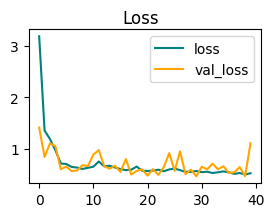

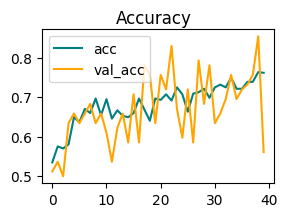

Fold Training Time: 0 hour(s) and 9 mins
Precision: 78.04877758026123  -  Recall: 78.04877758026123
Accuracy: 78.04877758026123
F1Score: 78.04877378228208
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/6925e11d-882a-4388-81a3-3df40ac97773
Epoch 1/40
72/72 [==============================] - ETA: 0s - loss: 2.1377 - accuracy: 0.5439
Epoch 1: val_loss improved from inf to 0.83032, saving model to ./checkpoints/INI-V0-1\FOLD-2
INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-2\assets


INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-2\assets


72/72 [==============================] - 22s 250ms/step - loss: 2.1377 - accuracy: 0.5439 - val_loss: 0.8303 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/40
72/72 [==============================] - ETA: 0s - loss: 0.8732 - accuracy: 0.6070
Epoch 2: val_loss improved from 0.83032 to 0.68355, saving model to ./checkpoints/INI-V0-1\FOLD-2
INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-2\assets


INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-2\assets


72/72 [==============================] - 18s 250ms/step - loss: 0.8732 - accuracy: 0.6070 - val_loss: 0.6835 - val_accuracy: 0.6341 - lr: 0.0010
Epoch 3/40
72/72 [==============================] - ETA: 0s - loss: 0.7558 - accuracy: 0.6316
Epoch 3: val_loss did not improve from 0.68355
72/72 [==============================] - 13s 176ms/step - loss: 0.7558 - accuracy: 0.6316 - val_loss: 0.8252 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/40
72/72 [==============================] - ETA: 0s - loss: 0.7280 - accuracy: 0.5982
Epoch 4: val_loss did not improve from 0.68355
72/72 [==============================] - 13s 176ms/step - loss: 0.7280 - accuracy: 0.5982 - val_loss: 1.1647 - val_accuracy: 0.5366 - lr: 0.0010
Epoch 5/40
72/72 [==============================] - ETA: 0s - loss: 0.6906 - accuracy: 0.6474
Epoch 5: val_loss improved from 0.68355 to 0.67624, saving model to ./checkpoints/INI-V0-1\FOLD-2
INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-2\assets


INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-2\assets


72/72 [==============================] - 18s 252ms/step - loss: 0.6906 - accuracy: 0.6474 - val_loss: 0.6762 - val_accuracy: 0.5122 - lr: 0.0010
Epoch 6/40
72/72 [==============================] - ETA: 0s - loss: 0.6436 - accuracy: 0.6316
Epoch 6: val_loss improved from 0.67624 to 0.65775, saving model to ./checkpoints/INI-V0-1\FOLD-2
INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-2\assets


INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-2\assets


72/72 [==============================] - 18s 247ms/step - loss: 0.6436 - accuracy: 0.6316 - val_loss: 0.6577 - val_accuracy: 0.6829 - lr: 0.0010
Epoch 7/40
72/72 [==============================] - ETA: 0s - loss: 0.6420 - accuracy: 0.6789
Epoch 7: val_loss improved from 0.65775 to 0.64284, saving model to ./checkpoints/INI-V0-1\FOLD-2
INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-2\assets


INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-2\assets


72/72 [==============================] - 17s 243ms/step - loss: 0.6420 - accuracy: 0.6789 - val_loss: 0.6428 - val_accuracy: 0.7073 - lr: 0.0010
Epoch 8/40
72/72 [==============================] - ETA: 0s - loss: 0.6145 - accuracy: 0.6877
Epoch 8: val_loss improved from 0.64284 to 0.55827, saving model to ./checkpoints/INI-V0-1\FOLD-2
INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-2\assets


INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-2\assets


72/72 [==============================] - 19s 253ms/step - loss: 0.6145 - accuracy: 0.6877 - val_loss: 0.5583 - val_accuracy: 0.7439 - lr: 0.0010
Epoch 9/40
72/72 [==============================] - ETA: 0s - loss: 0.6100 - accuracy: 0.6982
Epoch 9: val_loss improved from 0.55827 to 0.51966, saving model to ./checkpoints/INI-V0-1\FOLD-2
INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-2\assets


INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-2\assets


72/72 [==============================] - 17s 242ms/step - loss: 0.6100 - accuracy: 0.6982 - val_loss: 0.5197 - val_accuracy: 0.7195 - lr: 0.0010
Epoch 10/40
72/72 [==============================] - ETA: 0s - loss: 0.6173 - accuracy: 0.6632
Epoch 10: val_loss did not improve from 0.51966
72/72 [==============================] - 13s 177ms/step - loss: 0.6173 - accuracy: 0.6632 - val_loss: 0.5511 - val_accuracy: 0.7805 - lr: 0.0010
Epoch 11/40
72/72 [==============================] - ETA: 0s - loss: 0.6096 - accuracy: 0.6772
Epoch 11: val_loss did not improve from 0.51966
72/72 [==============================] - 13s 175ms/step - loss: 0.6096 - accuracy: 0.6772 - val_loss: 0.5671 - val_accuracy: 0.7317 - lr: 0.0010
Epoch 12/40
72/72 [==============================] - ETA: 0s - loss: 0.6557 - accuracy: 0.6439
Epoch 12: val_loss did not improve from 0.51966
72/72 [==============================] - 13s 175ms/step - loss: 0.6557 - accuracy: 0.6439 - val_loss: 0.5524 - val_accuracy: 0.7439 - lr

INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-2\assets


72/72 [==============================] - 18s 246ms/step - loss: 0.6066 - accuracy: 0.6947 - val_loss: 0.5147 - val_accuracy: 0.7439 - lr: 0.0010
Epoch 15/40
72/72 [==============================] - ETA: 0s - loss: 0.5947 - accuracy: 0.6895
Epoch 15: val_loss did not improve from 0.51469
72/72 [==============================] - 13s 177ms/step - loss: 0.5947 - accuracy: 0.6895 - val_loss: 0.6239 - val_accuracy: 0.5610 - lr: 0.0010
Epoch 16/40
72/72 [==============================] - ETA: 0s - loss: 0.6500 - accuracy: 0.6526
Epoch 16: val_loss did not improve from 0.51469
72/72 [==============================] - 13s 175ms/step - loss: 0.6500 - accuracy: 0.6526 - val_loss: 0.6197 - val_accuracy: 0.6707 - lr: 0.0010
Epoch 17/40
72/72 [==============================] - ETA: 0s - loss: 0.5742 - accuracy: 0.7088
Epoch 17: val_loss did not improve from 0.51469
72/72 [==============================] - 13s 175ms/step - loss: 0.5742 - accuracy: 0.7088 - val_loss: 0.5484 - val_accuracy: 0.6707 - lr

INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-2\assets


72/72 [==============================] - 18s 249ms/step - loss: 0.5857 - accuracy: 0.6982 - val_loss: 0.4833 - val_accuracy: 0.8049 - lr: 0.0010
Epoch 19/40
72/72 [==============================] - ETA: 0s - loss: 0.5879 - accuracy: 0.7140
Epoch 19: val_loss did not improve from 0.48332
72/72 [==============================] - 13s 176ms/step - loss: 0.5879 - accuracy: 0.7140 - val_loss: 0.5718 - val_accuracy: 0.6951 - lr: 0.0010
Epoch 20/40
72/72 [==============================] - ETA: 0s - loss: 0.5724 - accuracy: 0.7000
Epoch 20: val_loss did not improve from 0.48332
72/72 [==============================] - 13s 175ms/step - loss: 0.5724 - accuracy: 0.7000 - val_loss: 0.5289 - val_accuracy: 0.6951 - lr: 0.0010
Epoch 21/40
72/72 [==============================] - ETA: 0s - loss: 0.5517 - accuracy: 0.7105
Epoch 21: val_loss did not improve from 0.48332
72/72 [==============================] - 13s 177ms/step - loss: 0.5517 - accuracy: 0.7105 - val_loss: 1.2211 - val_accuracy: 0.5122 - lr

INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-2\assets


72/72 [==============================] - 17s 241ms/step - loss: 0.4872 - accuracy: 0.7561 - val_loss: 0.4686 - val_accuracy: 0.7561 - lr: 6.0000e-04
Epoch 32/40
72/72 [==============================] - ETA: 0s - loss: 0.4794 - accuracy: 0.7982
Epoch 32: val_loss improved from 0.46861 to 0.45627, saving model to ./checkpoints/INI-V0-1\FOLD-2
INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-2\assets


INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-2\assets


72/72 [==============================] - 18s 244ms/step - loss: 0.4794 - accuracy: 0.7982 - val_loss: 0.4563 - val_accuracy: 0.7805 - lr: 6.0000e-04
Epoch 33/40
72/72 [==============================] - ETA: 0s - loss: 0.4727 - accuracy: 0.7912
Epoch 33: val_loss did not improve from 0.45627
72/72 [==============================] - 13s 176ms/step - loss: 0.4727 - accuracy: 0.7912 - val_loss: 0.5356 - val_accuracy: 0.6951 - lr: 6.0000e-04
Epoch 34/40
72/72 [==============================] - ETA: 0s - loss: 0.5031 - accuracy: 0.7368
Epoch 34: val_loss did not improve from 0.45627
72/72 [==============================] - 13s 175ms/step - loss: 0.5031 - accuracy: 0.7368 - val_loss: 0.5496 - val_accuracy: 0.7439 - lr: 6.0000e-04
Epoch 35/40
72/72 [==============================] - ETA: 0s - loss: 0.4871 - accuracy: 0.7684
Epoch 35: val_loss did not improve from 0.45627
72/72 [==============================] - 13s 175ms/step - loss: 0.4871 - accuracy: 0.7684 - val_loss: 0.5392 - val_accuracy:

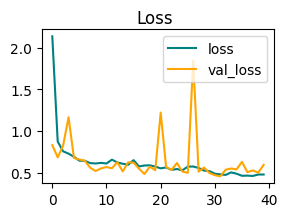

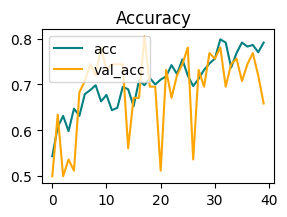

Fold Training Time: 0 hour(s) and 9 mins
Precision: 84.84848737716675  -  Recall: 68.29268336296082
Accuracy: 78.04877758026123
F1Score: 75.67568282879297
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/1cc35690-e3dd-43d6-b569-5d38b40eca5b
Epoch 1/40
72/72 [==============================] - ETA: 0s - loss: 2.7462 - accuracy: 0.5930
Epoch 1: val_loss improved from inf to 0.75893, saving model to ./checkpoints/INI-V0-1\FOLD-3
INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-3\assets


INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-3\assets


72/72 [==============================] - 22s 252ms/step - loss: 2.7462 - accuracy: 0.5930 - val_loss: 0.7589 - val_accuracy: 0.4268 - lr: 0.0010
Epoch 2/40
72/72 [==============================] - ETA: 0s - loss: 1.1245 - accuracy: 0.5789
Epoch 2: val_loss improved from 0.75893 to 0.73950, saving model to ./checkpoints/INI-V0-1\FOLD-3
INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-3\assets


INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-3\assets


72/72 [==============================] - 17s 244ms/step - loss: 1.1245 - accuracy: 0.5789 - val_loss: 0.7395 - val_accuracy: 0.4146 - lr: 0.0010
Epoch 3/40
72/72 [==============================] - ETA: 0s - loss: 0.9242 - accuracy: 0.5842
Epoch 3: val_loss did not improve from 0.73950
72/72 [==============================] - 13s 182ms/step - loss: 0.9242 - accuracy: 0.5842 - val_loss: 0.8542 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/40
72/72 [==============================] - ETA: 0s - loss: 0.9061 - accuracy: 0.5649
Epoch 4: val_loss did not improve from 0.73950
72/72 [==============================] - 13s 178ms/step - loss: 0.9061 - accuracy: 0.5649 - val_loss: 0.8129 - val_accuracy: 0.5122 - lr: 0.0010
Epoch 5/40
72/72 [==============================] - ETA: 0s - loss: 0.7419 - accuracy: 0.5895
Epoch 5: val_loss improved from 0.73950 to 0.69568, saving model to ./checkpoints/INI-V0-1\FOLD-3
INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-3\assets


INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-3\assets


72/72 [==============================] - 18s 250ms/step - loss: 0.7419 - accuracy: 0.5895 - val_loss: 0.6957 - val_accuracy: 0.5366 - lr: 0.0010
Epoch 6/40
72/72 [==============================] - ETA: 0s - loss: 0.6805 - accuracy: 0.6351
Epoch 6: val_loss improved from 0.69568 to 0.69311, saving model to ./checkpoints/INI-V0-1\FOLD-3
INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-3\assets


INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-3\assets


72/72 [==============================] - 18s 250ms/step - loss: 0.6805 - accuracy: 0.6351 - val_loss: 0.6931 - val_accuracy: 0.5854 - lr: 0.0010
Epoch 7/40
72/72 [==============================] - ETA: 0s - loss: 0.6441 - accuracy: 0.6316
Epoch 7: val_loss did not improve from 0.69311
72/72 [==============================] - 13s 179ms/step - loss: 0.6441 - accuracy: 0.6316 - val_loss: 0.9040 - val_accuracy: 0.5244 - lr: 0.0010
Epoch 8/40
72/72 [==============================] - ETA: 0s - loss: 0.6092 - accuracy: 0.6719
Epoch 8: val_loss did not improve from 0.69311
72/72 [==============================] - 13s 178ms/step - loss: 0.6092 - accuracy: 0.6719 - val_loss: 0.7082 - val_accuracy: 0.6220 - lr: 0.0010
Epoch 9/40
72/72 [==============================] - ETA: 0s - loss: 0.6439 - accuracy: 0.6684
Epoch 9: val_loss did not improve from 0.69311
72/72 [==============================] - 13s 178ms/step - loss: 0.6439 - accuracy: 0.6684 - val_loss: 1.3498 - val_accuracy: 0.4268 - lr: 0.00

INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-3\assets


72/72 [==============================] - 18s 250ms/step - loss: 0.6147 - accuracy: 0.7000 - val_loss: 0.6148 - val_accuracy: 0.6707 - lr: 0.0010
Epoch 15/40
72/72 [==============================] - ETA: 0s - loss: 0.6132 - accuracy: 0.6912
Epoch 15: val_loss did not improve from 0.61476
72/72 [==============================] - 13s 180ms/step - loss: 0.6132 - accuracy: 0.6912 - val_loss: 0.7381 - val_accuracy: 0.6707 - lr: 0.0010
Epoch 16/40
72/72 [==============================] - ETA: 0s - loss: 0.6126 - accuracy: 0.6702
Epoch 16: val_loss did not improve from 0.61476
72/72 [==============================] - 13s 181ms/step - loss: 0.6126 - accuracy: 0.6702 - val_loss: 0.6574 - val_accuracy: 0.6463 - lr: 0.0010
Epoch 17/40
72/72 [==============================] - ETA: 0s - loss: 0.5670 - accuracy: 0.7211
Epoch 17: val_loss did not improve from 0.61476
72/72 [==============================] - 13s 181ms/step - loss: 0.5670 - accuracy: 0.7211 - val_loss: 0.8533 - val_accuracy: 0.5854 - lr

INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-3\assets


72/72 [==============================] - 18s 254ms/step - loss: 0.5837 - accuracy: 0.6860 - val_loss: 0.5964 - val_accuracy: 0.7439 - lr: 0.0010
Epoch 22/40
72/72 [==============================] - ETA: 0s - loss: 0.5890 - accuracy: 0.6772
Epoch 22: val_loss did not improve from 0.59637
72/72 [==============================] - 13s 177ms/step - loss: 0.5890 - accuracy: 0.6772 - val_loss: 0.6457 - val_accuracy: 0.6707 - lr: 0.0010
Epoch 23/40
72/72 [==============================] - ETA: 0s - loss: 0.5631 - accuracy: 0.7228
Epoch 23: val_loss did not improve from 0.59637
72/72 [==============================] - 13s 177ms/step - loss: 0.5631 - accuracy: 0.7228 - val_loss: 0.7249 - val_accuracy: 0.5610 - lr: 0.0010
Epoch 24/40
72/72 [==============================] - ETA: 0s - loss: 0.5410 - accuracy: 0.7491
Epoch 24: val_loss improved from 0.59637 to 0.56533, saving model to ./checkpoints/INI-V0-1\FOLD-3
INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-3\assets


INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-3\assets


72/72 [==============================] - 18s 244ms/step - loss: 0.5410 - accuracy: 0.7491 - val_loss: 0.5653 - val_accuracy: 0.7073 - lr: 0.0010
Epoch 25/40
72/72 [==============================] - ETA: 0s - loss: 0.5459 - accuracy: 0.7070
Epoch 25: val_loss did not improve from 0.56533
72/72 [==============================] - 13s 179ms/step - loss: 0.5459 - accuracy: 0.7070 - val_loss: 0.7713 - val_accuracy: 0.6585 - lr: 0.0010
Epoch 26/40
72/72 [==============================] - ETA: 0s - loss: 0.5941 - accuracy: 0.7000
Epoch 26: val_loss did not improve from 0.56533
72/72 [==============================] - 13s 178ms/step - loss: 0.5941 - accuracy: 0.7000 - val_loss: 1.0140 - val_accuracy: 0.6341 - lr: 0.0010
Epoch 27/40
72/72 [==============================] - ETA: 0s - loss: 0.5504 - accuracy: 0.7211
Epoch 27: val_loss did not improve from 0.56533
72/72 [==============================] - 13s 176ms/step - loss: 0.5504 - accuracy: 0.7211 - val_loss: 0.7668 - val_accuracy: 0.5732 - lr

INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-3\assets


72/72 [==============================] - 17s 243ms/step - loss: 0.4672 - accuracy: 0.7737 - val_loss: 0.5486 - val_accuracy: 0.7439 - lr: 6.0000e-04
Epoch 36/40
72/72 [==============================] - ETA: 0s - loss: 0.4759 - accuracy: 0.7632
Epoch 36: val_loss did not improve from 0.54857
72/72 [==============================] - 13s 177ms/step - loss: 0.4759 - accuracy: 0.7632 - val_loss: 0.9631 - val_accuracy: 0.6341 - lr: 6.0000e-04
Epoch 37/40
72/72 [==============================] - ETA: 0s - loss: 0.5028 - accuracy: 0.7404
Epoch 37: val_loss did not improve from 0.54857
72/72 [==============================] - 13s 175ms/step - loss: 0.5028 - accuracy: 0.7404 - val_loss: 0.5744 - val_accuracy: 0.7073 - lr: 6.0000e-04
Epoch 38/40
72/72 [==============================] - ETA: 0s - loss: 0.4628 - accuracy: 0.7772
Epoch 38: val_loss did not improve from 0.54857
72/72 [==============================] - 13s 177ms/step - loss: 0.4628 - accuracy: 0.7772 - val_loss: 0.9457 - val_accuracy:

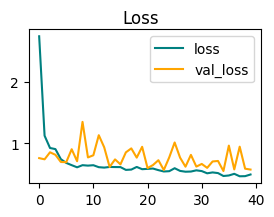

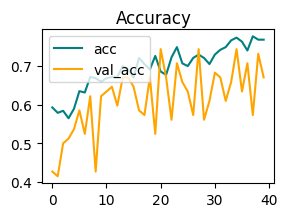

Fold Training Time: 0 hour(s) and 9 mins
Precision: 75.0  -  Recall: 73.17073345184326
Accuracy: 74.39024448394775
F1Score: 74.07407496800747
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/594438e2-e8b9-4ab0-a231-c7b61c01ca52
Epoch 1/40
72/72 [==============================] - ETA: 0s - loss: 2.5900 - accuracy: 0.5814
Epoch 1: val_loss improved from inf to 0.72083, saving model to ./checkpoints/INI-V0-1\FOLD-4
INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-4\assets


INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-4\assets


72/72 [==============================] - 23s 258ms/step - loss: 2.5900 - accuracy: 0.5814 - val_loss: 0.7208 - val_accuracy: 0.4691 - lr: 0.0010
Epoch 2/40
72/72 [==============================] - ETA: 0s - loss: 1.0039 - accuracy: 0.5814
Epoch 2: val_loss improved from 0.72083 to 0.71129, saving model to ./checkpoints/INI-V0-1\FOLD-4
INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-4\assets


INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-4\assets


72/72 [==============================] - 18s 245ms/step - loss: 1.0039 - accuracy: 0.5814 - val_loss: 0.7113 - val_accuracy: 0.4938 - lr: 0.0010
Epoch 3/40
72/72 [==============================] - ETA: 0s - loss: 0.7932 - accuracy: 0.6042
Epoch 3: val_loss did not improve from 0.71129
72/72 [==============================] - 13s 178ms/step - loss: 0.7932 - accuracy: 0.6042 - val_loss: 0.7335 - val_accuracy: 0.4815 - lr: 0.0010
Epoch 4/40
72/72 [==============================] - ETA: 0s - loss: 0.6714 - accuracy: 0.6567
Epoch 4: val_loss did not improve from 0.71129
72/72 [==============================] - 13s 180ms/step - loss: 0.6714 - accuracy: 0.6567 - val_loss: 1.0267 - val_accuracy: 0.4691 - lr: 0.0010
Epoch 5/40
72/72 [==============================] - ETA: 0s - loss: 0.7303 - accuracy: 0.6200
Epoch 5: val_loss improved from 0.71129 to 0.68957, saving model to ./checkpoints/INI-V0-1\FOLD-4
INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-4\assets


INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-4\assets


72/72 [==============================] - 19s 262ms/step - loss: 0.7303 - accuracy: 0.6200 - val_loss: 0.6896 - val_accuracy: 0.5802 - lr: 0.0010
Epoch 6/40
72/72 [==============================] - ETA: 0s - loss: 0.6392 - accuracy: 0.6585
Epoch 6: val_loss did not improve from 0.68957
72/72 [==============================] - 13s 179ms/step - loss: 0.6392 - accuracy: 0.6585 - val_loss: 1.1044 - val_accuracy: 0.5432 - lr: 0.0010
Epoch 7/40
72/72 [==============================] - ETA: 0s - loss: 0.6778 - accuracy: 0.6602
Epoch 7: val_loss did not improve from 0.68957
72/72 [==============================] - 13s 177ms/step - loss: 0.6778 - accuracy: 0.6602 - val_loss: 0.7369 - val_accuracy: 0.5432 - lr: 0.0010
Epoch 8/40
72/72 [==============================] - ETA: 0s - loss: 0.6130 - accuracy: 0.6637
Epoch 8: val_loss improved from 0.68957 to 0.59109, saving model to ./checkpoints/INI-V0-1\FOLD-4
INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-4\assets


INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-4\assets


72/72 [==============================] - 18s 246ms/step - loss: 0.6130 - accuracy: 0.6637 - val_loss: 0.5911 - val_accuracy: 0.6543 - lr: 0.0010
Epoch 9/40
72/72 [==============================] - ETA: 0s - loss: 0.5846 - accuracy: 0.6900
Epoch 9: val_loss did not improve from 0.59109
72/72 [==============================] - 13s 181ms/step - loss: 0.5846 - accuracy: 0.6900 - val_loss: 0.6590 - val_accuracy: 0.6049 - lr: 0.0010
Epoch 10/40
72/72 [==============================] - ETA: 0s - loss: 0.5906 - accuracy: 0.6918
Epoch 10: val_loss improved from 0.59109 to 0.58495, saving model to ./checkpoints/INI-V0-1\FOLD-4
INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-4\assets


INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-4\assets


72/72 [==============================] - 18s 246ms/step - loss: 0.5906 - accuracy: 0.6918 - val_loss: 0.5850 - val_accuracy: 0.6790 - lr: 0.0010
Epoch 11/40
72/72 [==============================] - ETA: 0s - loss: 0.5830 - accuracy: 0.6900
Epoch 11: val_loss did not improve from 0.58495
72/72 [==============================] - 13s 178ms/step - loss: 0.5830 - accuracy: 0.6900 - val_loss: 0.6646 - val_accuracy: 0.6420 - lr: 0.0010
Epoch 12/40
72/72 [==============================] - ETA: 0s - loss: 0.5870 - accuracy: 0.6988
Epoch 12: val_loss did not improve from 0.58495
72/72 [==============================] - 13s 178ms/step - loss: 0.5870 - accuracy: 0.6988 - val_loss: 0.7313 - val_accuracy: 0.6173 - lr: 0.0010
Epoch 13/40
72/72 [==============================] - ETA: 0s - loss: 0.5848 - accuracy: 0.7023
Epoch 13: val_loss did not improve from 0.58495
72/72 [==============================] - 13s 178ms/step - loss: 0.5848 - accuracy: 0.7023 - val_loss: 0.9158 - val_accuracy: 0.5185 - lr

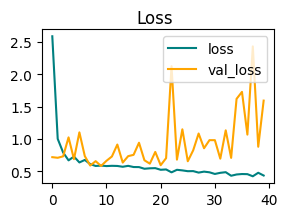

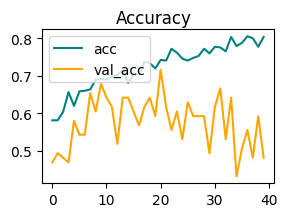

Fold Training Time: 0 hour(s) and 9 mins
Precision: 71.875  -  Recall: 57.499998807907104
Accuracy: 67.90123581886292
F1Score: 63.8888837698643
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/da2f362e-04ae-422b-bafc-ffad50805037
Epoch 1/40
72/72 [==============================] - ETA: 0s - loss: 2.0292 - accuracy: 0.5587
Epoch 1: val_loss improved from inf to 0.73172, saving model to ./checkpoints/INI-V0-1\FOLD-5
INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-5\assets


INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-5\assets


72/72 [==============================] - 22s 252ms/step - loss: 2.0292 - accuracy: 0.5587 - val_loss: 0.7317 - val_accuracy: 0.4938 - lr: 0.0010
Epoch 2/40
72/72 [==============================] - ETA: 0s - loss: 0.9192 - accuracy: 0.5849
Epoch 2: val_loss did not improve from 0.73172
72/72 [==============================] - 13s 178ms/step - loss: 0.9192 - accuracy: 0.5849 - val_loss: 1.1459 - val_accuracy: 0.4938 - lr: 0.0010
Epoch 3/40
72/72 [==============================] - ETA: 0s - loss: 0.7647 - accuracy: 0.6042
Epoch 3: val_loss did not improve from 0.73172
72/72 [==============================] - 13s 179ms/step - loss: 0.7647 - accuracy: 0.6042 - val_loss: 1.3912 - val_accuracy: 0.5062 - lr: 0.0010
Epoch 4/40
72/72 [==============================] - ETA: 0s - loss: 0.6634 - accuracy: 0.6497
Epoch 4: val_loss did not improve from 0.73172
72/72 [==============================] - 13s 182ms/step - loss: 0.6634 - accuracy: 0.6497 - val_loss: 1.6319 - val_accuracy: 0.4938 - lr: 0.00

INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-5\assets


72/72 [==============================] - 18s 252ms/step - loss: 0.6172 - accuracy: 0.6690 - val_loss: 0.6389 - val_accuracy: 0.6049 - lr: 0.0010
Epoch 9/40
72/72 [==============================] - ETA: 0s - loss: 0.6190 - accuracy: 0.6690
Epoch 9: val_loss did not improve from 0.63889
72/72 [==============================] - 13s 181ms/step - loss: 0.6190 - accuracy: 0.6690 - val_loss: 0.6945 - val_accuracy: 0.5802 - lr: 0.0010
Epoch 10/40
72/72 [==============================] - ETA: 0s - loss: 0.5724 - accuracy: 0.7023
Epoch 10: val_loss did not improve from 0.63889
72/72 [==============================] - 13s 178ms/step - loss: 0.5724 - accuracy: 0.7023 - val_loss: 0.8709 - val_accuracy: 0.5556 - lr: 0.0010
Epoch 11/40
72/72 [==============================] - ETA: 0s - loss: 0.5919 - accuracy: 0.6795
Epoch 11: val_loss did not improve from 0.63889
72/72 [==============================] - 13s 178ms/step - loss: 0.5919 - accuracy: 0.6795 - val_loss: 0.8104 - val_accuracy: 0.6049 - lr: 

INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-5\assets


72/72 [==============================] - 20s 280ms/step - loss: 0.5742 - accuracy: 0.7058 - val_loss: 0.6199 - val_accuracy: 0.6173 - lr: 0.0010
Epoch 15/40
72/72 [==============================] - ETA: 0s - loss: 0.5946 - accuracy: 0.6795
Epoch 15: val_loss did not improve from 0.61987
72/72 [==============================] - 13s 179ms/step - loss: 0.5946 - accuracy: 0.6795 - val_loss: 0.6640 - val_accuracy: 0.6173 - lr: 0.0010
Epoch 16/40
72/72 [==============================] - ETA: 0s - loss: 0.5594 - accuracy: 0.7075
Epoch 16: val_loss did not improve from 0.61987
72/72 [==============================] - 13s 180ms/step - loss: 0.5594 - accuracy: 0.7075 - val_loss: 0.7870 - val_accuracy: 0.5556 - lr: 0.0010
Epoch 17/40
72/72 [==============================] - ETA: 0s - loss: 0.5654 - accuracy: 0.7005
Epoch 17: val_loss did not improve from 0.61987
72/72 [==============================] - 13s 181ms/step - loss: 0.5654 - accuracy: 0.7005 - val_loss: 0.8903 - val_accuracy: 0.5802 - lr

INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-5\assets


72/72 [==============================] - 18s 249ms/step - loss: 0.5694 - accuracy: 0.7093 - val_loss: 0.6114 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 24/40
72/72 [==============================] - ETA: 0s - loss: 0.5538 - accuracy: 0.7285
Epoch 24: val_loss did not improve from 0.61137
72/72 [==============================] - 13s 181ms/step - loss: 0.5538 - accuracy: 0.7285 - val_loss: 0.7286 - val_accuracy: 0.6173 - lr: 0.0010
Epoch 25/40
72/72 [==============================] - ETA: 0s - loss: 0.5556 - accuracy: 0.7093
Epoch 25: val_loss did not improve from 0.61137
72/72 [==============================] - 13s 179ms/step - loss: 0.5556 - accuracy: 0.7093 - val_loss: 0.6578 - val_accuracy: 0.6420 - lr: 0.0010
Epoch 26/40
72/72 [==============================] - ETA: 0s - loss: 0.5390 - accuracy: 0.7198
Epoch 26: val_loss did not improve from 0.61137
72/72 [==============================] - 13s 178ms/step - loss: 0.5390 - accuracy: 0.7198 - val_loss: 0.6864 - val_accuracy: 0.6420 - lr

INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-5\assets


72/72 [==============================] - 18s 247ms/step - loss: 0.4959 - accuracy: 0.7478 - val_loss: 0.5975 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 33/40
72/72 [==============================] - ETA: 0s - loss: 0.5210 - accuracy: 0.7426
Epoch 33: val_loss did not improve from 0.59755
72/72 [==============================] - 13s 181ms/step - loss: 0.5210 - accuracy: 0.7426 - val_loss: 0.7411 - val_accuracy: 0.6420 - lr: 0.0010
Epoch 34/40
72/72 [==============================] - ETA: 0s - loss: 0.5131 - accuracy: 0.7601
Epoch 34: val_loss did not improve from 0.59755
72/72 [==============================] - 13s 179ms/step - loss: 0.5131 - accuracy: 0.7601 - val_loss: 1.1263 - val_accuracy: 0.5556 - lr: 0.0010
Epoch 35/40
72/72 [==============================] - ETA: 0s - loss: 0.4898 - accuracy: 0.7723
Epoch 35: val_loss did not improve from 0.59755
72/72 [==============================] - 13s 180ms/step - loss: 0.4898 - accuracy: 0.7723 - val_loss: 0.6864 - val_accuracy: 0.6543 - lr

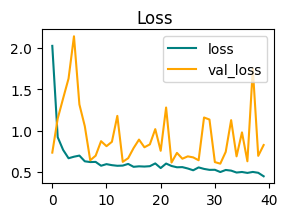

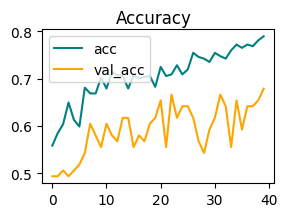

Fold Training Time: 0 hour(s) and 9 mins
Precision: 62.745100259780884  -  Recall: 80.0000011920929
Accuracy: 66.66666865348816
F1Score: 70.32967280749891
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/184ecaf7-f0fc-4fb5-92bb-34d610072fd2
Epoch 1/40
72/72 [==============================] - ETA: 0s - loss: 2.9660 - accuracy: 0.5429
Epoch 1: val_loss improved from inf to 0.73905, saving model to ./checkpoints/INI-V0-1\FOLD-6
INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-6\assets


INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-6\assets


72/72 [==============================] - 22s 254ms/step - loss: 2.9660 - accuracy: 0.5429 - val_loss: 0.7390 - val_accuracy: 0.5062 - lr: 0.0010
Epoch 2/40
72/72 [==============================] - ETA: 0s - loss: 0.9904 - accuracy: 0.5692
Epoch 2: val_loss did not improve from 0.73905
72/72 [==============================] - 13s 180ms/step - loss: 0.9904 - accuracy: 0.5692 - val_loss: 1.1128 - val_accuracy: 0.5062 - lr: 0.0010
Epoch 3/40
72/72 [==============================] - ETA: 0s - loss: 0.8819 - accuracy: 0.5832
Epoch 3: val_loss did not improve from 0.73905
72/72 [==============================] - 13s 180ms/step - loss: 0.8819 - accuracy: 0.5832 - val_loss: 0.8430 - val_accuracy: 0.5926 - lr: 0.0010
Epoch 4/40
72/72 [==============================] - ETA: 0s - loss: 0.7523 - accuracy: 0.5954
Epoch 4: val_loss improved from 0.73905 to 0.68005, saving model to ./checkpoints/INI-V0-1\FOLD-6
INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-6\assets


INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-6\assets


72/72 [==============================] - 18s 254ms/step - loss: 0.7523 - accuracy: 0.5954 - val_loss: 0.6800 - val_accuracy: 0.5802 - lr: 0.0010
Epoch 5/40
72/72 [==============================] - ETA: 0s - loss: 0.8379 - accuracy: 0.6060
Epoch 5: val_loss did not improve from 0.68005
72/72 [==============================] - 15s 209ms/step - loss: 0.8379 - accuracy: 0.6060 - val_loss: 0.7403 - val_accuracy: 0.6049 - lr: 0.0010
Epoch 6/40
72/72 [==============================] - ETA: 0s - loss: 0.6833 - accuracy: 0.6060
Epoch 6: val_loss did not improve from 0.68005
72/72 [==============================] - 16s 228ms/step - loss: 0.6833 - accuracy: 0.6060 - val_loss: 0.7824 - val_accuracy: 0.5802 - lr: 0.0010
Epoch 7/40
72/72 [==============================] - ETA: 0s - loss: 0.6603 - accuracy: 0.6165
Epoch 7: val_loss improved from 0.68005 to 0.59129, saving model to ./checkpoints/INI-V0-1\FOLD-6
INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-6\assets


INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-6\assets


72/72 [==============================] - 25s 354ms/step - loss: 0.6603 - accuracy: 0.6165 - val_loss: 0.5913 - val_accuracy: 0.7407 - lr: 0.0010
Epoch 8/40
72/72 [==============================] - ETA: 0s - loss: 0.5991 - accuracy: 0.6760
Epoch 8: val_loss did not improve from 0.59129
72/72 [==============================] - 15s 204ms/step - loss: 0.5991 - accuracy: 0.6760 - val_loss: 0.6349 - val_accuracy: 0.6543 - lr: 0.0010
Epoch 9/40
72/72 [==============================] - ETA: 0s - loss: 0.6365 - accuracy: 0.6760
Epoch 9: val_loss did not improve from 0.59129
72/72 [==============================] - 18s 247ms/step - loss: 0.6365 - accuracy: 0.6760 - val_loss: 0.6070 - val_accuracy: 0.6914 - lr: 0.0010
Epoch 10/40
72/72 [==============================] - ETA: 0s - loss: 0.6290 - accuracy: 0.6515
Epoch 10: val_loss improved from 0.59129 to 0.58877, saving model to ./checkpoints/INI-V0-1\FOLD-6
INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-6\assets


INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-6\assets


72/72 [==============================] - 23s 327ms/step - loss: 0.6290 - accuracy: 0.6515 - val_loss: 0.5888 - val_accuracy: 0.6914 - lr: 0.0010
Epoch 11/40
72/72 [==============================] - ETA: 0s - loss: 0.6019 - accuracy: 0.6585
Epoch 11: val_loss did not improve from 0.58877
72/72 [==============================] - 14s 196ms/step - loss: 0.6019 - accuracy: 0.6585 - val_loss: 0.7640 - val_accuracy: 0.5679 - lr: 0.0010
Epoch 12/40
72/72 [==============================] - ETA: 0s - loss: 0.6465 - accuracy: 0.6427
Epoch 12: val_loss did not improve from 0.58877
72/72 [==============================] - 14s 195ms/step - loss: 0.6465 - accuracy: 0.6427 - val_loss: 0.6627 - val_accuracy: 0.6296 - lr: 0.0010
Epoch 13/40
72/72 [==============================] - ETA: 0s - loss: 0.6134 - accuracy: 0.6567
Epoch 13: val_loss did not improve from 0.58877
72/72 [==============================] - 15s 208ms/step - loss: 0.6134 - accuracy: 0.6567 - val_loss: 0.6977 - val_accuracy: 0.6667 - lr

INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-6\assets


72/72 [==============================] - 20s 278ms/step - loss: 0.6412 - accuracy: 0.6375 - val_loss: 0.5594 - val_accuracy: 0.7284 - lr: 0.0010
Epoch 16/40
72/72 [==============================] - ETA: 0s - loss: 0.5903 - accuracy: 0.6830
Epoch 16: val_loss did not improve from 0.55942
72/72 [==============================] - 14s 196ms/step - loss: 0.5903 - accuracy: 0.6830 - val_loss: 0.6222 - val_accuracy: 0.6914 - lr: 0.0010
Epoch 17/40
72/72 [==============================] - ETA: 0s - loss: 0.5976 - accuracy: 0.6708
Epoch 17: val_loss did not improve from 0.55942
72/72 [==============================] - 14s 196ms/step - loss: 0.5976 - accuracy: 0.6708 - val_loss: 0.6811 - val_accuracy: 0.5432 - lr: 0.0010
Epoch 18/40
72/72 [==============================] - ETA: 0s - loss: 0.5922 - accuracy: 0.6725
Epoch 18: val_loss did not improve from 0.55942
72/72 [==============================] - 14s 198ms/step - loss: 0.5922 - accuracy: 0.6725 - val_loss: 0.5774 - val_accuracy: 0.7531 - lr

INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-6\assets


72/72 [==============================] - 20s 274ms/step - loss: 0.5329 - accuracy: 0.7338 - val_loss: 0.5531 - val_accuracy: 0.7531 - lr: 6.0000e-04
Epoch 33/40
72/72 [==============================] - ETA: 0s - loss: 0.5672 - accuracy: 0.7163
Epoch 33: val_loss did not improve from 0.55306
72/72 [==============================] - 14s 195ms/step - loss: 0.5672 - accuracy: 0.7163 - val_loss: 0.5928 - val_accuracy: 0.7284 - lr: 6.0000e-04
Epoch 34/40
72/72 [==============================] - ETA: 0s - loss: 0.5249 - accuracy: 0.7303
Epoch 34: val_loss did not improve from 0.55306
72/72 [==============================] - 14s 196ms/step - loss: 0.5249 - accuracy: 0.7303 - val_loss: 0.5807 - val_accuracy: 0.7284 - lr: 6.0000e-04
Epoch 35/40
72/72 [==============================] - ETA: 0s - loss: 0.5258 - accuracy: 0.7356
Epoch 35: val_loss did not improve from 0.55306
72/72 [==============================] - 14s 198ms/step - loss: 0.5258 - accuracy: 0.7356 - val_loss: 0.6439 - val_accuracy:

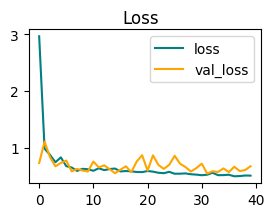

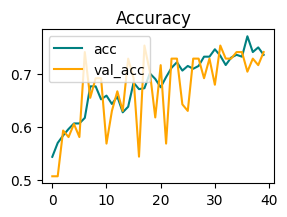

Fold Training Time: 0 hour(s) and 10 mins
Precision: 75.60975551605225  -  Recall: 75.60975551605225
Accuracy: 75.30864477157593
F1Score: 75.60975725119927
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Neptune initialized. Open in the app: offline/9428eb3c-c41d-4682-8e5a-a4ffcdcff0c6
Epoch 1/40
72/72 [==============================] - ETA: 0s - loss: 2.3495 - accuracy: 0.5657
Epoch 1: val_loss improved from inf to 0.76394, saving model to ./checkpoints/INI-V0-1\FOLD-7
INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-7\assets


INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-7\assets


72/72 [==============================] - 26s 296ms/step - loss: 2.3495 - accuracy: 0.5657 - val_loss: 0.7639 - val_accuracy: 0.4198 - lr: 0.0010
Epoch 2/40
72/72 [==============================] - ETA: 0s - loss: 1.1422 - accuracy: 0.5709
Epoch 2: val_loss improved from 0.76394 to 0.71395, saving model to ./checkpoints/INI-V0-1\FOLD-7
INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-7\assets


INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-7\assets


72/72 [==============================] - 23s 316ms/step - loss: 1.1422 - accuracy: 0.5709 - val_loss: 0.7140 - val_accuracy: 0.5556 - lr: 0.0010
Epoch 3/40
72/72 [==============================] - ETA: 0s - loss: 0.9273 - accuracy: 0.5762
Epoch 3: val_loss improved from 0.71395 to 0.65432, saving model to ./checkpoints/INI-V0-1\FOLD-7
INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-7\assets


INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-7\assets


72/72 [==============================] - 19s 261ms/step - loss: 0.9273 - accuracy: 0.5762 - val_loss: 0.6543 - val_accuracy: 0.5802 - lr: 0.0010
Epoch 4/40
72/72 [==============================] - ETA: 0s - loss: 0.7857 - accuracy: 0.5814
Epoch 4: val_loss did not improve from 0.65432
72/72 [==============================] - 13s 183ms/step - loss: 0.7857 - accuracy: 0.5814 - val_loss: 0.7581 - val_accuracy: 0.5062 - lr: 0.0010
Epoch 5/40
72/72 [==============================] - ETA: 0s - loss: 0.7521 - accuracy: 0.6095
Epoch 5: val_loss did not improve from 0.65432
72/72 [==============================] - 13s 182ms/step - loss: 0.7521 - accuracy: 0.6095 - val_loss: 0.6754 - val_accuracy: 0.6049 - lr: 0.0010
Epoch 6/40
72/72 [==============================] - ETA: 0s - loss: 0.6838 - accuracy: 0.6235
Epoch 6: val_loss did not improve from 0.65432
72/72 [==============================] - 14s 193ms/step - loss: 0.6838 - accuracy: 0.6235 - val_loss: 1.0204 - val_accuracy: 0.5432 - lr: 0.00

INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-7\assets


72/72 [==============================] - 23s 319ms/step - loss: 0.5749 - accuracy: 0.6865 - val_loss: 0.5668 - val_accuracy: 0.7284 - lr: 6.0000e-04
Epoch 17/40
72/72 [==============================] - ETA: 0s - loss: 0.5603 - accuracy: 0.6900
Epoch 17: val_loss did not improve from 0.56685
72/72 [==============================] - 14s 194ms/step - loss: 0.5603 - accuracy: 0.6900 - val_loss: 0.7214 - val_accuracy: 0.5432 - lr: 6.0000e-04
Epoch 18/40
72/72 [==============================] - ETA: 0s - loss: 0.5550 - accuracy: 0.7128
Epoch 18: val_loss did not improve from 0.56685
72/72 [==============================] - 15s 206ms/step - loss: 0.5550 - accuracy: 0.7128 - val_loss: 0.7201 - val_accuracy: 0.6420 - lr: 6.0000e-04
Epoch 19/40
72/72 [==============================] - ETA: 0s - loss: 0.5451 - accuracy: 0.7128
Epoch 19: val_loss did not improve from 0.56685
72/72 [==============================] - 14s 200ms/step - loss: 0.5451 - accuracy: 0.7128 - val_loss: 0.7000 - val_accuracy:

INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-7\assets


72/72 [==============================] - 19s 271ms/step - loss: 0.5390 - accuracy: 0.6918 - val_loss: 0.5552 - val_accuracy: 0.7284 - lr: 6.0000e-04
Epoch 24/40
72/72 [==============================] - ETA: 0s - loss: 0.5505 - accuracy: 0.7145
Epoch 24: val_loss did not improve from 0.55522
72/72 [==============================] - 17s 230ms/step - loss: 0.5505 - accuracy: 0.7145 - val_loss: 1.0194 - val_accuracy: 0.5432 - lr: 6.0000e-04
Epoch 25/40
72/72 [==============================] - ETA: 0s - loss: 0.5258 - accuracy: 0.7285
Epoch 25: val_loss improved from 0.55522 to 0.52993, saving model to ./checkpoints/INI-V0-1\FOLD-7
INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-7\assets


INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-7\assets


72/72 [==============================] - 21s 295ms/step - loss: 0.5258 - accuracy: 0.7285 - val_loss: 0.5299 - val_accuracy: 0.7037 - lr: 6.0000e-04
Epoch 26/40
72/72 [==============================] - ETA: 0s - loss: 0.5658 - accuracy: 0.6883
Epoch 26: val_loss did not improve from 0.52993
72/72 [==============================] - 14s 190ms/step - loss: 0.5658 - accuracy: 0.6883 - val_loss: 0.8159 - val_accuracy: 0.5432 - lr: 6.0000e-04
Epoch 27/40
72/72 [==============================] - ETA: 0s - loss: 0.5496 - accuracy: 0.7040
Epoch 27: val_loss improved from 0.52993 to 0.47941, saving model to ./checkpoints/INI-V0-1\FOLD-7
INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-7\assets


INFO:tensorflow:Assets written to: ./checkpoints/INI-V0-1\FOLD-7\assets


72/72 [==============================] - 18s 252ms/step - loss: 0.5496 - accuracy: 0.7040 - val_loss: 0.4794 - val_accuracy: 0.8025 - lr: 6.0000e-04
Epoch 28/40
72/72 [==============================] - ETA: 0s - loss: 0.5459 - accuracy: 0.7215
Epoch 28: val_loss did not improve from 0.47941
72/72 [==============================] - 13s 180ms/step - loss: 0.5459 - accuracy: 0.7215 - val_loss: 0.6684 - val_accuracy: 0.6543 - lr: 6.0000e-04
Epoch 29/40
72/72 [==============================] - ETA: 0s - loss: 0.5806 - accuracy: 0.7180
Epoch 29: val_loss did not improve from 0.47941
72/72 [==============================] - 13s 178ms/step - loss: 0.5806 - accuracy: 0.7180 - val_loss: 1.5846 - val_accuracy: 0.5309 - lr: 6.0000e-04
Epoch 30/40
72/72 [==============================] - ETA: 0s - loss: 0.5162 - accuracy: 0.7461
Epoch 30: val_loss did not improve from 0.47941
72/72 [==============================] - 13s 179ms/step - loss: 0.5162 - accuracy: 0.7461 - val_loss: 0.7349 - val_accuracy:

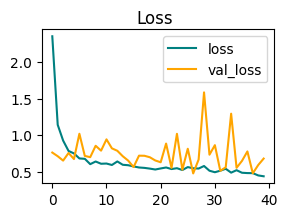

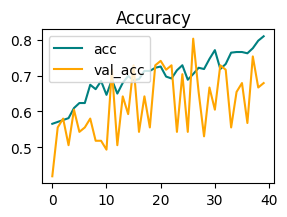

Fold Training Time: 0 hour(s) and 10 mins
Precision: 79.0697693824768  -  Recall: 82.92682766914368
Accuracy: 80.24691343307495
F1Score: 80.95237709779634
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
Total Training Time: 1 hour(s) and 17 mins


In [103]:
# ============================
# Log performance of each fold
# ============================

precisions = []
recalls = []
accuracies = []
f1_scores = []

counter = 0
start = perf_counter()
for train, test in kfold.split(train_x, train_y):
    start_fold = perf_counter()

    run = neptune.init_run(
        name= f"{model_name}-FOLD_{counter}",
        project=project_name,
        mode="offline"     # To prevent issue when internet sucks. Just manually sync it
    )  # your credentials

    run["parameters"] = params
    model = make_model(params)
    train_dataset = tf.data.Dataset.from_tensor_slices((train_x[train], train_y[train]))
    train_fold = train_dataset.shuffle(buffer_size=train_dataset.cardinality(), seed=1).batch(params['batch_size'])
    
    test_dataset = tf.data.Dataset.from_tensor_slices((train_x[test], train_y[test]))
    test_fold = test_dataset.shuffle(buffer_size=test_dataset.cardinality(), seed=1).batch(params['batch_size'])
    
    hist = model.fit(train_fold, 
                     validation_data=test_fold,
                     batch_size=params['batch_size'],
                     epochs=params['epochs'],
                     verbose=1,
                     callbacks=create_callbacks(counter))
    end_fold = perf_counter()

    # PLOTTING ==================================================
    run["fig-train_loss"].upload(plot_loss(hist))
    run["fig-train_acc"].upload(plot_acc(hist))
    
    # EVALUATING ==================================================
    model = tf.keras.models.load_model(checkpoint_path + str(counter))
    
    pre = Precision()
    rec = Recall()
    b_acc = tf.keras.metrics.BinaryAccuracy()
    for batch in test_fold.as_numpy_iterator():
        X, y = batch
        yhat = model.predict(X, verbose=0)
        pre.update_state(y, yhat)
        rec.update_state(y, yhat)
        b_acc.update_state(y, yhat)
        
    precisions.append(pre.result().numpy() * 100)
    recalls.append(rec.result().numpy() * 100)
    accuracies.append(b_acc.result().numpy() * 100)
    f1 = (2 * (pre.result().numpy() * rec.result().numpy()) / (pre.result().numpy() + rec.result().numpy())) * 100 
    
    f1_scores.append(f1)
    
    run["eval/ACC/"] = accuracies[counter]
    run["eval/REC/"] = recalls[counter]
    run["eval/PRE/"] = precisions[counter]
    run["eval/F1"] = f1_scores[counter]

    # SAVE MODEL TO NEPTUNE AI =======================================
    model_save_path = f"./models/V0-1_Fold-{counter}.keras"
    model.save(model_save_path)
    run['/checkpoint/model'].upload(model_save_path)
    
    # PRINTING RESULTS ===========================================
    print(f'Fold Training Time: {math.floor((end_fold-start_fold)/3600) } hour(s) and {math.floor((end_fold-start_fold)/60)%60} mins')
    print(f'Precision: {precisions[counter]}  -  Recall: {recalls[counter]}')
    print(f'Accuracy: {accuracies[counter]}')
    print(f'F1Score: {f1_scores[counter]}')
    
    run.stop()
    
    counter += 1

end = perf_counter()

print(f'Total Training Time: {math.floor((end-start)/3600) } hour(s) and {math.floor((end-start)/60)%60} mins')
# Valid ones are 6:44pm and beyond

# Get Average Performance of Model

## Save to Neptune AI

In [104]:
run = neptune.init_run(
        name= f"{model_name}-AVG",
        project=project_name,
        mode='offline',
        # api_token=api_token, # Api token is saved in user's environemnt variables
    )  # your credentials

run["eval/PRE/"] = avg_rate(precisions)
run["eval/REC/"] = avg_rate(recalls)
run["eval/ACC/"] = avg_rate(accuracies)
run["eval/F1"] = avg_rate(f1_scores)

run.stop()

[neptune] [info   ] Neptune initialized. Open in the app: offline/99983889-c115-42a9-bd66-9b80b00978ed
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!


## Save to Tensorboard

In [105]:
# Command to access TensorBoard HParams:

# tensorboard --logdir PATH/logs/hparam_tuning
with tf.summary.create_file_writer(f'./for_INI_model/logs/hparam_tuning/{model_name}').as_default():
    hparams = {
        'CONV_F1': 16,
        'CONV_F2': 16,
        'CONV_F3': 64,
        'DROPOUT': 0.2,
        'D_UNITS_1': 128,
        'D_UNITS_2': 64,
    }
    hp.hparams(hparams)
    tf.summary.scalar('PRE', avg_rate(precisions), step=1)
    tf.summary.scalar('REC', avg_rate(recalls), step=1)
    tf.summary.scalar('ACC', avg_rate(accuracies), step=1)
    tf.summary.scalar('F1', avg_rate(f1_scores), step=1)

# Asd

# Others

In [ ]:
model= make_model()
model.fit(
    x_train,
    y_train,
    validation_data=(x_test,y_test),
    epochs=params["epochs"],
    batch_size=params["batch_size"],
    callbacks=create_callbacks(0),
)

In [ ]:
true_test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
true_test_set = true_test_dataset.shuffle(buffer_size=true_test_dataset.cardinality(), seed=1).batch(64)

f1 = F1Score()
pre = Precision()
rec = Recall()
c_acc = CategoricalAccuracy()
for batch in true_test_set.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    yhat_max = []
    for i in yhat:
        maxed = np.argmax(i)
        yhat_max.append(maxed)
    yhat = np.array(yhat_max)
    f1.update_state(y, yhat)
    pre.update_state(y, yhat)
    rec.update_state(y, yhat)
    c_acc.update_state(y, yhat)


In [ ]:
run["eval/ACC/"] = float(c_acc.result().numpy() * 100)
run["eval/REC/"] = float(rec.result().numpy() * 100)
run["eval/PRE/"] = float(pre.result().numpy() * 100)


In [ ]:
run.stop()

In [ ]:
eval_metrics = model.evaluate(x_test, y_test, verbose=0)
for j, metric in enumerate(eval_metrics):
    run["eval/AVG-ACC/{}".format(model.metrics_names[j])] = metric

run.stop()

In [ ]:
for j, metric in enumerate(eval_metrics):
    print(model.metrics_names[j])

## Neptune AI Notes